# 摘要

# 理论模型

对于期货，其趋势性的一个重要来源是展期收益率（定义见：[期限结构](.\期限结构.ipynb)）的持续性（主要是其符号的持续性）。

对于商品期货来说，波动性比较低，需要的持仓时间较长，早期的趋势策略一般基于日线指标。一般趋势策略的胜率都不会很高，40%~50% 是比较理想的，而盈亏比会比较高。趋势策略的夏普比率都不会很高，1~2 倍比较常见。一个策略的容量取决于它在活跃品种上的盈利程度。商品期货趋势策略或许会有很长的平台期、回撤期，但由于它跟股票、债券、货币等其他投资品种的相关性很低，因此作为资产配置的一个标的以分散风险。（\cite{LiWei:2018}）

一般来说，越短期的趋势越容易预测。（\cite{LiWei:2018}）

# 实证分析

In [1]:
# coding=utf-8
import sys
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
sys.path.append("D:\\HST\\QuantStudio")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2();

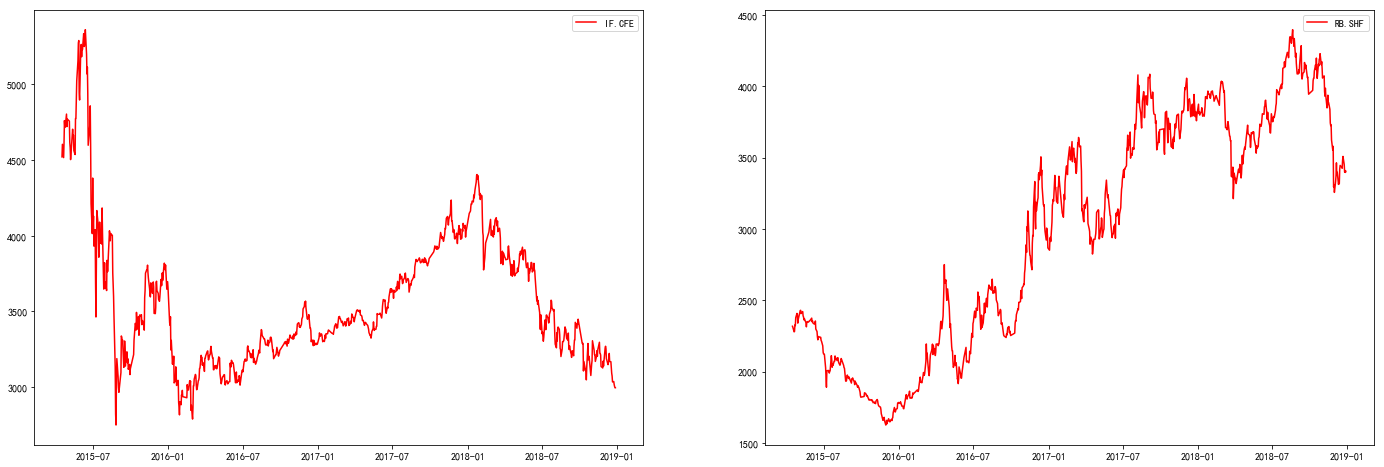

In [15]:
# 参数设置和数据准备
IDs = ["IF.CFE", "RB.SHF"]# 考察的 ID
StartDT = dt.datetime(2015, 4, 16)# 回测开始日期
EndDT = dt.datetime(2018, 12, 31)# 回测截止日期
PriceFactor = "收盘价(元)"

WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid="CFFEX", start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=IDs, dts=DTs).iloc[0,:,:]
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
# 获取股指期货的价格数据
TempIDs = pd.Series(IDs)
CFEIDs = TempIDs[TempIDs.str.contains("CFE")].tolist()
if CFEIDs:
    FT = WDB.getTable("中国股指期货日行情")
    CCPrice = FT.readData(factor_names=[PriceFactor], ids=CFEIDs, dts=DTs).iloc[0]
    TempIDs = pd.Series(MonthIDs)
    MonthPrice = FT.readData(factor_names=[PriceFactor], ids=TempIDs[TempIDs.str.contains("CFE")].tolist(), dts=DTs).iloc[0]
    # 对连续合约的价格进行调整
    AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in CFEIDs}
else:
    CCPrice = pd.DataFrame(index=DTs)
    AdjCCPrice = {}
# 获取商品期货的价格数据
TempIDs = pd.Series(IDs)
CommodityIDs = TempIDs[~TempIDs.str.contains("CFE")].tolist()
if CommodityIDs:
    FT = WDB.getTable("中国商品期货日行情")
    CCPrice = pd.merge(CCPrice, FT.readData(factor_names=[PriceFactor], ids=CommodityIDs, dts=DTs).iloc[0], left_index=True, right_index=True)
    TempIDs = pd.Series(MonthIDs)
    MonthPrice = FT.readData(factor_names=[PriceFactor], ids=TempIDs[~TempIDs.str.contains("CFE")].tolist(), dts=DTs).iloc[0]
    # 对连续合约的价格进行调整
    AdjCCPrice.update({iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in CommodityIDs})
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, CCPrice.columns]
WDB.disconnect()

import matplotlib.gridspec as gridspec
nID = len(IDs)
nRow, nCol = nID//3+(nID%3!=0), min(3, nID)
Fig = plt.figure(figsize=(min(32, 16+(nCol-1)*8), 8*nRow))
AxesGrid = gridspec.GridSpec(nRow, nCol)
for i in range(nID):
    iAxes = plt.subplot(AxesGrid[i//nCol, i%nCol])
    iAxes.plot(CCPrice.index, CCPrice.values[:, i], color='r', label=CCPrice.columns[i])
    iAxes.legend(loc='best');

## 趋势检测

下面测试期货收益率的序列相关性, 设置不同的回溯期和持有期，遍历寻找相关性最强的回溯期和持有期。

In [16]:
# 遍历寻找相关性最强的回溯期和持有期
TargetID = "RB.SHF"# 目标 ID
LookBackPeriods = [1, 5, 10, 25, 60, 120, 250]# 回溯期
HoldingPeriods = [1, 5, 10, 25, 60, 120, 250]# 持有期

from scipy import stats
TargetPrice = AdjCCPrice.loc[:, TargetID]
Rslt = pd.DataFrame(np.full((len(LookBackPeriods)*len(HoldingPeriods), 4), np.nan), columns=["LookBack", "Holding", "Correlation", "p-Value"])
for i, iLookBack in enumerate(tqdm_notebook(LookBackPeriods)):
    LagReturn = TargetPrice / TargetPrice.shift(iLookBack) - 1
    for j, jHolding in enumerate(HoldingPeriods):
        FutReturn = TargetPrice.shift(-jHolding) / TargetPrice - 1
        if iLookBack>=jHolding: IndepSet = np.arange(0, TargetPrice.shape[0], jHolding)
        else: IndepSet = np.arange(0, TargetPrice.shape[0], iLookBack)
        ijLagReturn = LagReturn.values[IndepSet]
        ijFutReturn = FutReturn.values[IndepSet]
        ijMask = (pd.notnull(ijLagReturn) & pd.notnull(ijFutReturn))
        ijCorr, ijpVal = stats.pearsonr(ijLagReturn[ijMask], ijFutReturn[ijMask])
        Rslt.iloc[i*len(HoldingPeriods)+j] = (iLookBack, jHolding, ijCorr, ijpVal)
display(Rslt)

,LookBack,Holding,Correlation,p-Value
0,1.0,1.0,-0.010885,0.743525
1,1.0,5.0,-0.021994,0.509438
2,1.0,10.0,-0.009246,0.782139
3,1.0,25.0,0.013490,0.689106
4,1.0,60.0,-0.042000,0.222060
5,1.0,120.0,-0.018783,0.598797
6,1.0,250.0,-0.004114,0.916175
7,5.0,1.0,-0.021173,0.525379
8,5.0,5.0,-0.033529,0.655000
9,5.0,10.0,-0.002770,0.970648


下面利用方差比检验检测趋势性。

In [4]:
# Variance Ratio 检验
import matlab
import matlab.engine
MatlabEngine = matlab.engine.start_matlab(option="-nodesktop")
VRTest = MatlabEngine.vratiotest(matlab.double(TargetPrice.values.tolist()), "IID", True, nargout=3)
MatlabEngine.quit()
print("---------- Variance Ratio Test ----------",
      ("Statistic : %f" % VRTest[2]), 
      ("pvalue : %f" % VRTest[1]), sep="\n")

---------- Variance Ratio Test ----------
Statistic : -0.727661
pvalue : 0.466821


## 单资产趋势策略

对于单资产的最简单的趋势策略：
1. 在每个持有期期末计算回溯期收益率。
2. 如果回溯期收益率和持有期收益率正相关，回溯期收益率为正做多 1 手，回溯期收益率为负做空 1 手；如果回溯期收益率和持有期收益率负相关，回溯期收益率为正做空 1 手，回溯期收益率为负做多 1 手。
3. 在两个持有期之间仓位保持不变。

,0
起始时点,2015-04-16 00:00:00
结束时点,2018-12-28 00:00:00
时点数,908
总收益率,-0.312457
年化收益率,-0.0961927
年化波动率,0.289018
Sharpe比率,-0.332826
胜率,0.562775
最大回撤率,0.545939
最大回撤开始时点,2016-05-25 00:00:00


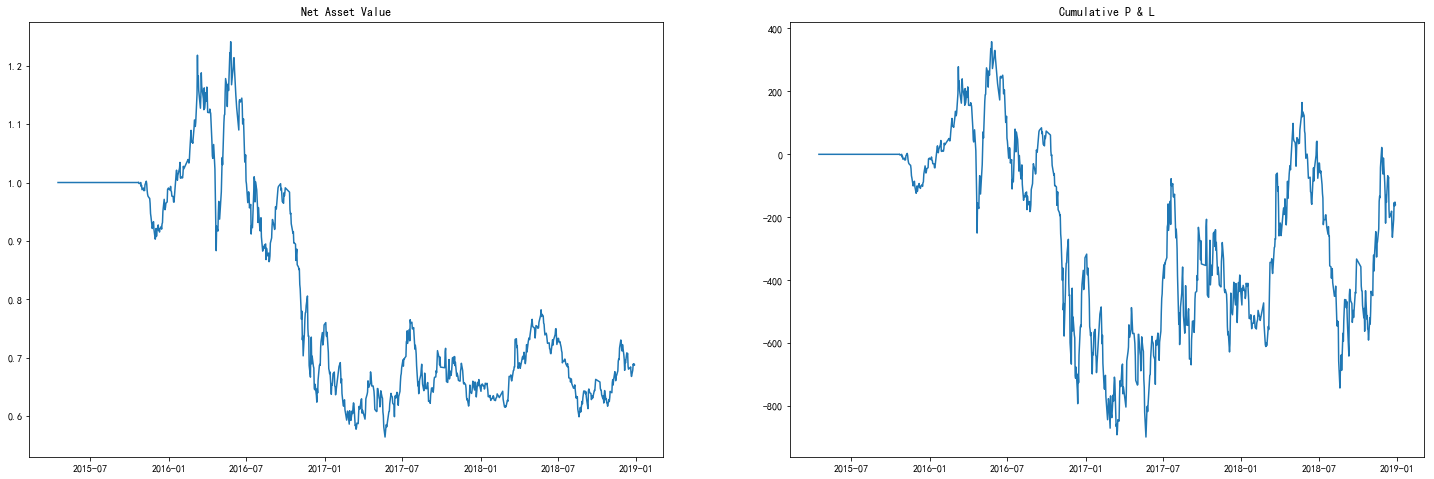

In [20]:
# 简单单资产趋势策略
TargetID = "RB.SHF"# 目标 ID
LookBack = 120# 回溯期
Holding = 25# 持有期
PosCorr = False# 是否是正相关

nDT = TargetPrice.shape[0]
TargetPrice = AdjCCPrice.loc[:, TargetID]
NumUnits = np.full((nDT, ), np.nan)
HoldingMask = np.full((nDT, ), False)
HoldingMask[np.arange(0, nDT, Holding)] = True
LagReturn = TargetPrice / TargetPrice.shift(LookBack) - 1
NumUnits[HoldingMask] = 0
NumUnits[HoldingMask & (LagReturn>0)] = (1 if PosCorr else -1)
NumUnits[HoldingMask & (LagReturn<0)] = (-1 if PosCorr else 1)
NumUnits = pd.Series(NumUnits, index=TargetPrice.index).fillna(method="pad")
Return, PNL, _, _ = QS.Tools.Strategy.testNumStrategy(NumUnits.values.reshape((nDT,1)), TargetPrice.values.reshape((nDT,1)))
Return, PNL = pd.Series(Return, index=TargetPrice.index), pd.DataFrame(PNL, index=TargetPrice.index, columns=[TargetID])
NAV = (1 + Return).cumprod()

# 展示策略表现
display(QS.Tools.Strategy.summaryStrategy(NAV.values, dts=NAV.index.tolist()))
Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(NAV)
Axes[0].set_title("Net Asset Value")
Axes[1].plot(PNL.sum(axis=1).cumsum())
Axes[1].set_title("Cumulative P & L");

\cite{Chan:2013} 给出的单资产趋势策略：
1. 在每个时点计算回溯期收益率。
2. 如果回溯期收益率和持有期收益率正相关，当前的回溯期收益率为正则增加多头资金比例，回溯期收益率为负增加空头资金比例；如果回溯期收益率和持有期收益率负相关，回溯期收益率为正增加空头资金比例，回溯期收益率为负增加多头资金比例。每次增加的资金比例为回溯期长度的倒数。

,0
起始时点,2015-04-16 00:00:00
结束时点,2018-12-28 00:00:00
时点数,908
总收益率,-0.46273
年化收益率,-0.15441
年化波动率,0.263788
Sharpe比率,-0.585356
胜率,0.546256
最大回撤率,0.627895
最大回撤开始时点,2016-05-25 00:00:00


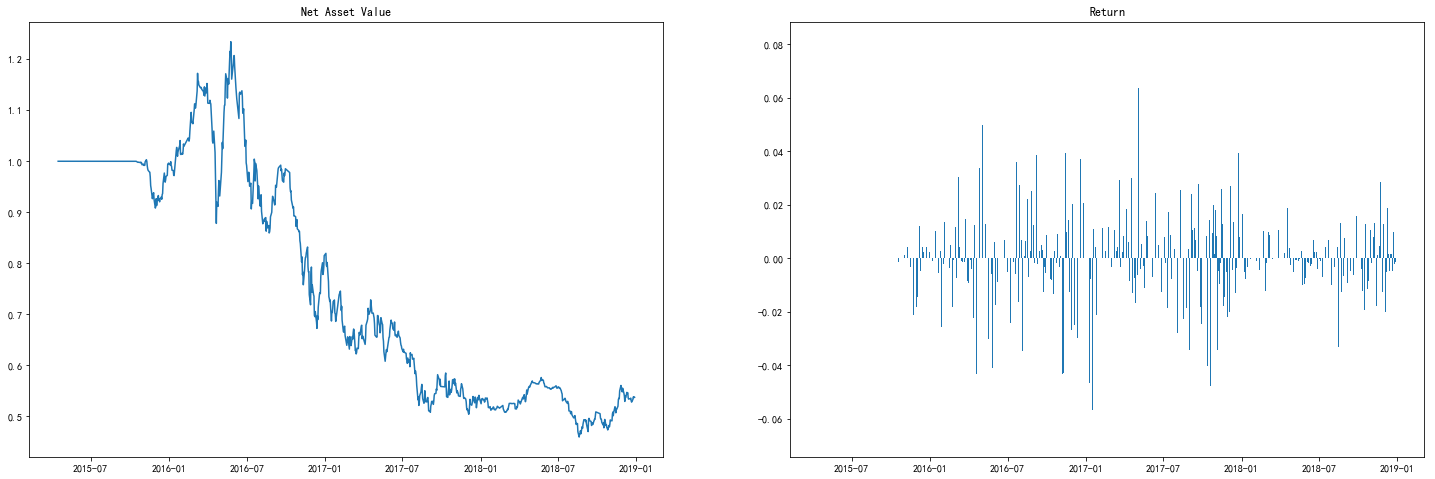

In [22]:
# 渐进式单资产趋势策略
TargetID = "RB.SHF"# 目标 ID
LookBack = 120# 回溯期
Holding = 25# 持有期
PosCorr = False# 是否是正相关

TargetPrice = AdjCCPrice.loc[:, TargetID]
nDT = TargetPrice.shape[0]
Portfolio = np.full((nDT, ), 0)
LagReturn = TargetPrice / TargetPrice.shift(LookBack) - 1
for i in range(Holding):
    iMask = (LagReturn.shift(i)>0)
    Portfolio[iMask] += (1 if PosCorr else -1)
    iMask = (LagReturn.shift(i)<0)
    Portfolio[iMask] += (-1 if PosCorr else 1)
Portfolio = pd.Series(Portfolio, index=TargetPrice.index) / Holding
Return, _ = QS.Tools.Strategy.testPortfolioStrategy(Portfolio.values.reshape((nDT,1)), TargetPrice.values.reshape((nDT,1)))
Return = pd.Series(Return, index=TargetPrice.index)
NAV = (1 + Return).cumprod()

# 展示策略表现
display(QS.Tools.Strategy.summaryStrategy(NAV.values, dts=NAV.index.tolist()))
Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(NAV)
Axes[0].set_title("Net Asset Value")
Axes[1].bar(Return.index, Return)
Axes[1].set_title("Return");

基于 Bolling Band 的单资产趋势策略：
1. 在每个时点按照回溯期计算 Zscore 分数。
2. 如果 Zscore 分数大于上轨阈值，则做多 1 手；如果 Zscore 分数小于下轨阈值，则最空 1 手。

,0
起始时点,2015-04-16 00:00:00
结束时点,2018-12-28 00:00:00
时点数,908
总收益率,0.040703
年化收益率,0.0108291
年化波动率,0.171749
Sharpe比率,0.0630516
胜率,0.762115
最大回撤率,0.227132
最大回撤开始时点,2016-11-07 00:00:00


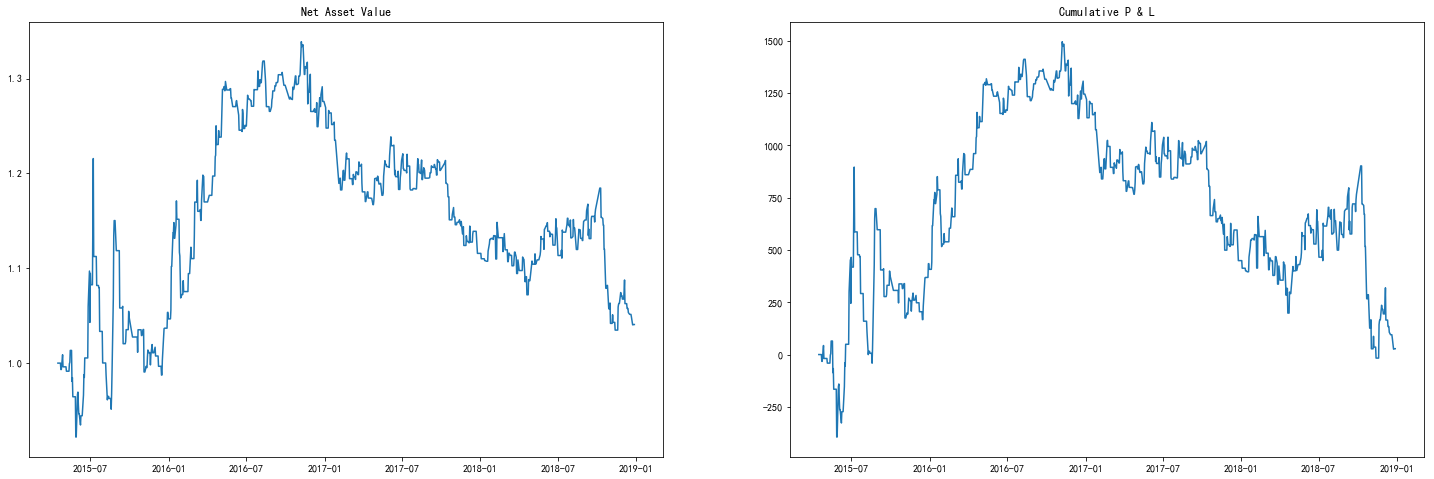

In [26]:
# 基于 Bolling Band 的单资产趋势策略
TargetID = "RB.SHF"# 目标 ID
LookBack = 5# 回溯期
EntryThreshold = 1# 发出信号的阈值

TargetPrice = AdjCCPrice.loc[:, TargetID]
nDT = TargetPrice.shape[0]
Zscore = (TargetPrice - TargetPrice.rolling(LookBack).mean()) / TargetPrice.rolling(LookBack).cov()**0.5
NumUnits = np.zeros(TargetPrice.shape[0])
NumUnits[Zscore.values>EntryThreshold] = 1
NumUnits[Zscore.values<-EntryThreshold] = -1
Return, PNL, _, _ = QS.Tools.Strategy.testNumStrategy(NumUnits.reshape((nDT, 1)), AdjCCPrice.values)
Return, PNL = pd.Series(Return, index=CCPrice.index), pd.DataFrame(PNL, index=CCPrice.index, columns=CCPrice.columns)
NAV = (1 + Return).cumprod()

# 展示策略表现
display(QS.Tools.Strategy.summaryStrategy(NAV.values, dts=NAV.index.tolist()))
Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(NAV)
Axes[0].set_title("Net Asset Value")
Axes[1].plot(PNL.sum(axis=1).cumsum())
Axes[1].set_title("Cumulative P & L");

## 基于期限结构的趋势策略

首先对展期收益率进行估计

Average Annualized Roll Return: 8.92%



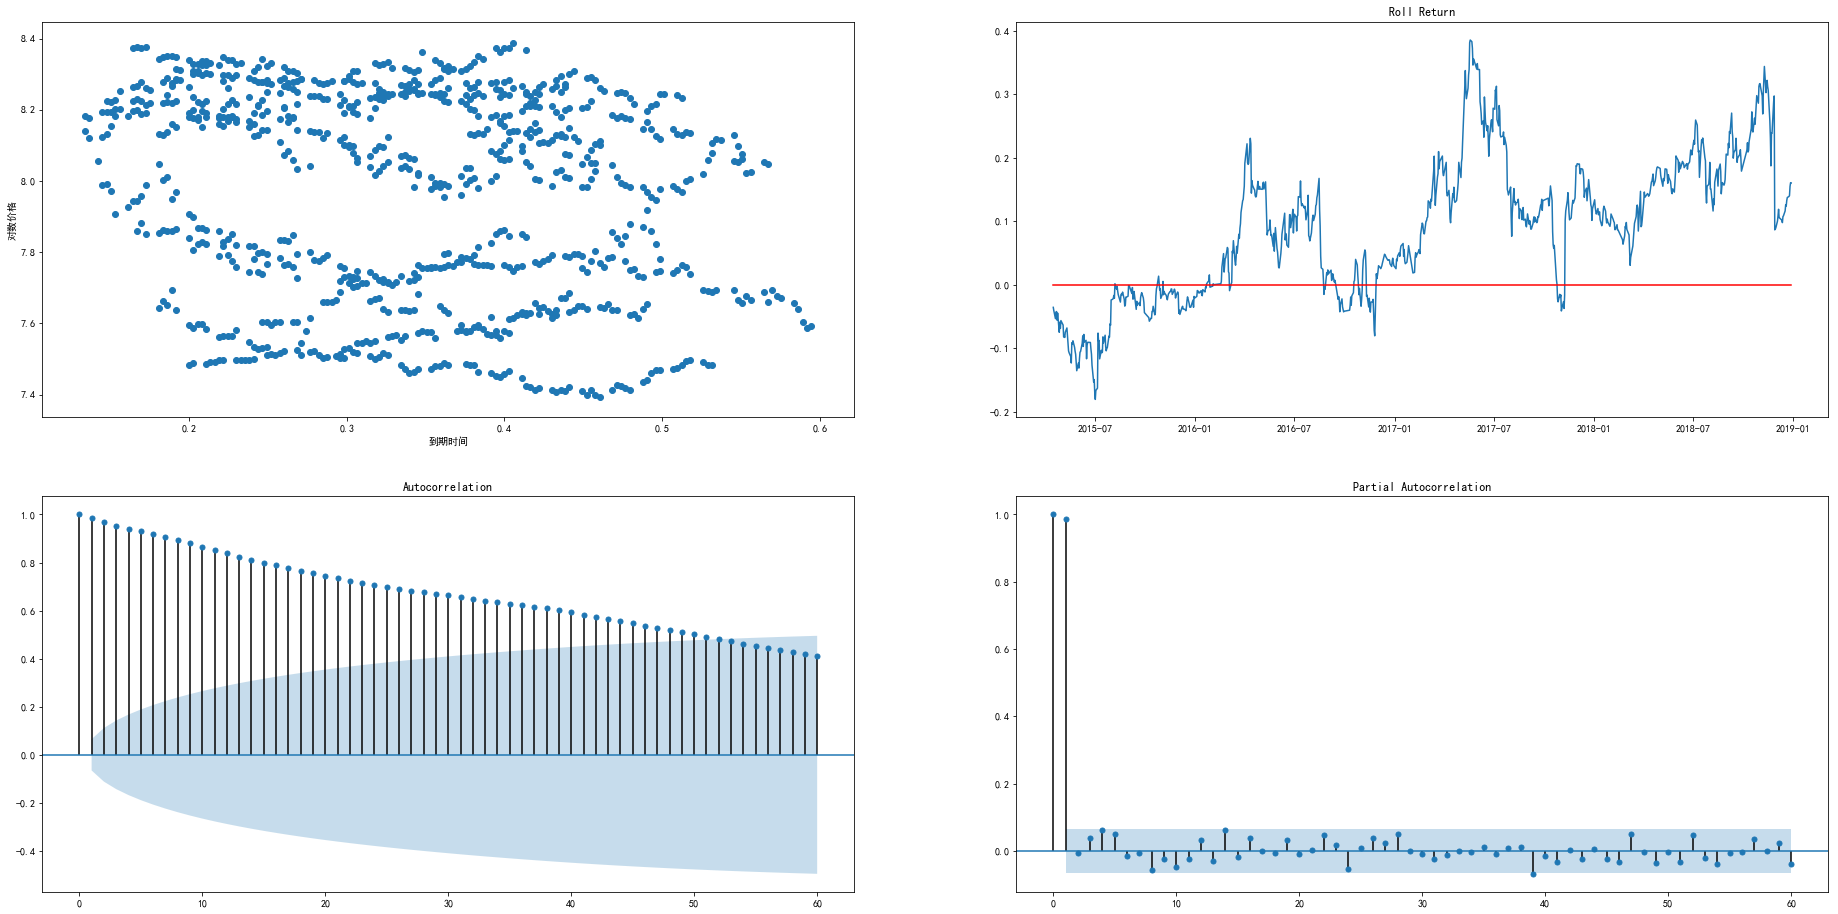

In [27]:
# 使用主力合约和次主力合约估计展期收益率
MID, SID = "RB.SHF", "RB_S.SHF"# 主力合约, 次主力合约

WDB.connect()
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=[MID, SID], dts=DTs).iloc[0, :, :]
# 获取主力和次主力合约的月合约到期日
MSMonthIDs = FutureIDMap.values.flatten()
MSMonthIDs = sorted(np.unique(MSMonthIDs[pd.notnull(MSMonthIDs)]))
FT = WDB.getTable("中国期货基本资料")
LastTradeDate = FT.readData(factor_names=["最后交易日期"], ids=MSMonthIDs, dts=[EndDT]).iloc[0, 0]
LastTradeDate = pd.DataFrame([FutureIDMap[iID].apply(lambda x: LastTradeDate[x] if pd.notnull(x) else None) for iID in [MID,SID]],index=[MID,SID]).T
ExpirationDays = pd.DataFrame(np.nan, index=LastTradeDate.index, columns=LastTradeDate.columns)
for i, iDT in enumerate(DTs):
    ExpirationDays.iloc[i] = LastTradeDate.iloc[i].apply(lambda x: (dt.datetime.strptime(x, "%Y%m%d") - iDT).days)
# 获取期货合约的价格
if MID.find("CFE")!=-1: FT = WDB.getTable("中国股指期货日行情")
else: FT = WDB.getTable("中国商品期货日行情")
MSPrice = FT.readData(factor_names=[PriceFactor], ids=[MID, SID], dts=DTs).iloc[0]
MSMonthPrice = FT.readData(factor_names=[PriceFactor], ids=MSMonthIDs, dts=DTs).iloc[0]
WDB.disconnect();

Fun = lambda x: (dt.datetime.strptime(x.iloc[0], "%Y%m%d") - dt.datetime.strptime(x.iloc[1], "%Y%m%d")).days / 365 if (pd.notnull(x.iloc[0]) and pd.notnull(x.iloc[1])) else np.nan
TimeDelta = LastTradeDate.loc[:, [MID, SID]].apply(Fun, axis=1)
RollYield_MS = np.diff(np.log(MSPrice), axis=1)[:, 0] / TimeDelta
print("Average Annualized Roll Return: %.2f%%" % (RollYield_MS.mean()*100, ), end="\n\n")

Fig, Axes = plt.subplots(2, 2, figsize=(32, 16))
Axes[0, 0].scatter(ExpirationDays.iloc[:, 0].values / 365, np.log(MSPrice.iloc[:, 0].values))
Axes[0, 0].set_xlabel("到期时间")
Axes[0, 0].set_ylabel("对数价格");
Axes[0, 1].plot(RollYield_MS)
Axes[0, 1].plot(RollYield_MS.index, np.zeros(RollYield_MS.shape[0]), color="r")
Axes[0, 1].set_title("Roll Return")
sm.graphics.tsa.plot_acf(RollYield_MS[pd.notnull(RollYield_MS)].values, lags=60, ax=Axes[1, 0])
sm.graphics.tsa.plot_pacf(RollYield_MS[pd.notnull(RollYield_MS)].values, lags=60, ax=Axes[1, 1]);

基于展期收益率的买入并持有的趋势策略为：当展期收益率大于某个阈值时做多；小于某个阈值时做空；否则空仓。

,0
起始时点,2015-04-16 00:00:00
结束时点,2018-12-28 00:00:00
时点数,908
总收益率,0.816306
年化收益率,0.174826
年化波动率,0.298397
Sharpe比率,0.585882
胜率,0.540749
最大回撤率,0.311071
最大回撤开始时点,2016-04-21 00:00:00


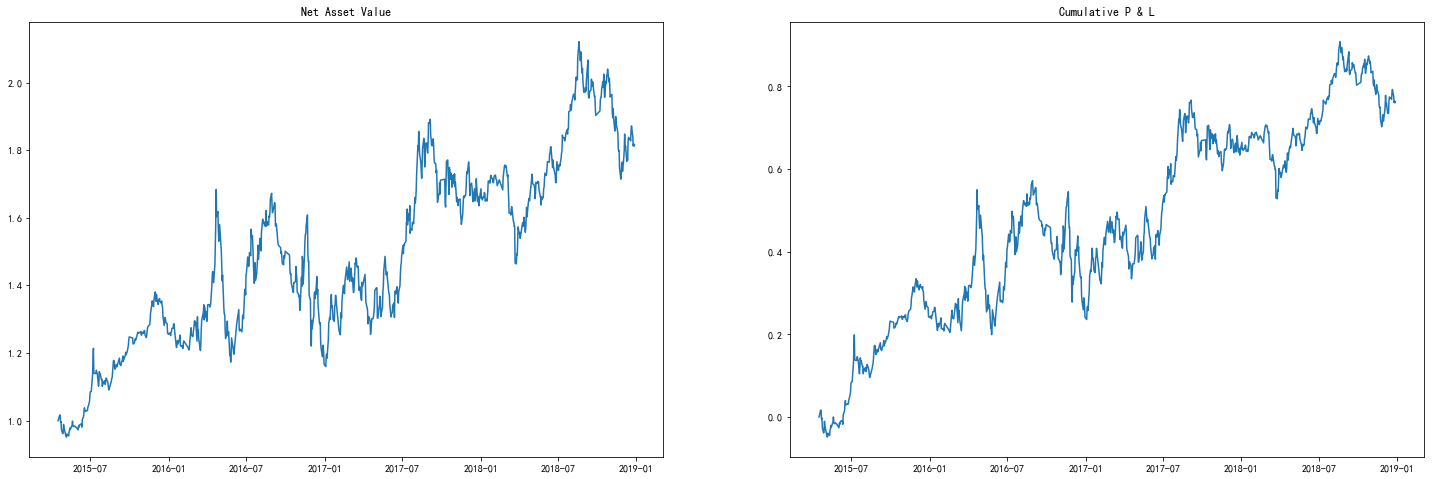

In [28]:
# 基于展期收益率的买入并持有趋势策略
LongThreshold, ShortThreshold = 0.0, -0.0# 做多和做空的展期收益率阈值

# 对连续合约的价格进行前复权调整
AdjMPrice = QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[MID], MSMonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=False)

Amount = np.zeros(AdjMPrice.shape)
Amount[RollYield_MS.values >= LongThreshold] = 1
Amount[RollYield_MS.values <= ShortThreshold] = -1
Return, PNL, _, _ = QS.Tools.Strategy.testNumStrategy((Amount / AdjMPrice).values.reshape((Amount.shape[0],1)), AdjMPrice.values.reshape((AdjMPrice.shape[0],1)))
Return, PNL = pd.Series(Return, index=AdjMPrice.index), pd.DataFrame(PNL, index=AdjMPrice.index)
NAV = (1+Return).cumprod()

# 展示策略表现
display(QS.Tools.Strategy.summaryStrategy(NAV.values, dts=NAV.index.tolist()))
Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(NAV)
Axes[0].set_title("Net Asset Value")
Axes[1].plot(PNL.sum(axis=1).cumsum())
Axes[1].set_title("Cumulative P & L");

前面的买入并持有策略需要承受现货收益率的风险，因而策略表现波动较大，可以通过反向交易现货（现货 ETF）对冲掉现货波动的风险

当展期收益率大于某个阈值时做多期货，做空现货（或者空仓）；小于某个阈值时做空期货，做多现货；否则空仓。

,0
起始时点,2015-04-16 00:00:00
结束时点,2018-12-28 00:00:00
时点数,908
总收益率,0.284262
年化收益率,0.0698755
年化波动率,0.0454133
Sharpe比率,1.53866
胜率,0.552863
最大回撤率,0.0470288
最大回撤开始时点,2015-07-03 00:00:00


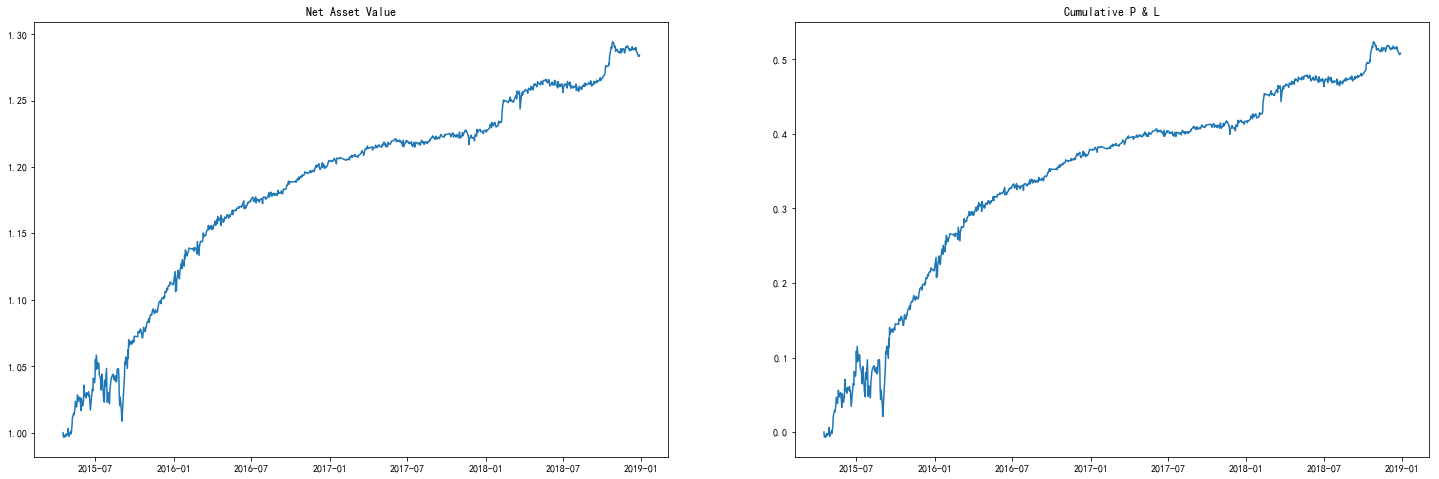

In [15]:
# 基于展期收益率的对冲趋势策略
LongThreshold, ShortThreshold = 0.0, -0.0

# 以 ETF 作为现货的替代
ETFID = "510300.SH"
WDB.connect()
ETFPrice = WDB.getTable("中国封闭式基金日行情").readData(factor_names=["复权收盘价(元)"], ids=[ETFID], dts=DTs).iloc[0, :, 0]
WDB.disconnect()

# 对连续合约的价格进行前复权调整
AdjMPrice = QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[MID], MSMonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=False)

Amount = np.zeros((AdjMPrice.shape[0], 2))
Mask = (RollYield_MS.values >= LongThreshold)
Amount[Mask, 0] = 1
Amount[Mask, 1] = -1
Mask = (RollYield_MS.values <= ShortThreshold)
Amount[Mask, 0] = -1
Amount[Mask, 1] = 1
Price = np.c_[AdjMPrice.values, ETFPrice.values]
Return, PNL, _, _ = QS.Tools.Strategy.testNumStrategy(Amount / Price, Price)
Return, PNL = pd.Series(Return, index=AdjMPrice.index), pd.DataFrame(PNL, index=AdjMPrice.index)
NAV = (1+Return).cumprod()

# 展示策略表现
display(QS.Tools.Strategy.summaryStrategy(NAV.values, dts=NAV.index.tolist()))
Fig, Axes = plt.subplots(1, 2, figsize=(25, 8))
Axes[0].plot(NAV)
Axes[0].set_title("Net Asset Value")
Axes[1].plot(PNL.sum(axis=1).cumsum())
Axes[1].set_title("Cumulative P & L");

# References

[<a id="cit-Chan:2013" href="#call-Chan:2013">Chan:2013</a>] Ernest Chan, ``_Algorithmic trading: winning strategies and their rationale_'',  2013.

